# Fire department Project

## Load in the data for the Fire Deparmtent Calls and import the necessary packages

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sodapy import Socrata
from sklearn import model_selection, metrics, linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
encoder = LabelEncoder()
pd.set_option('display.max_columns', None)

In [2]:
# This controls whether we save the data later
save_data = False

In [3]:
file_path = "./Fire_Department_Calls_for_Service.csv"
final_file_path = "./Fire_Department_Calls_for_Service_final.csv"
final = False
if os.path.isfile(final_file_path):
    fire_department = pd.read_csv(final_file_path)
    final = True
elif os.path.isfile(file_path):
    fire_df = pd.read_csv(file_path)
    weatherData = pd.read_csv("72494.csv")    
else:
    # if file does not exist, then get the data. This will take a long time (IE > 1hr)
    client = Socrata("data.sfgov.org", None)
    # This will take a long time to get all the data (IE > 1hr)
    # So we will only get 1 million results of the most recent data
    amount = (10**3)*1000
    results = client.get("nuek-vuh3", limit=(amount))
    fire_df = pd.DataFrame.from_records(results)
    fire_df.to_csv(file_path)
    fire_df.head()
    weatherData = pd.read_csv("72494.csv")

C:\Users\Sean4\AppData\Local\Temp\ipykernel_23068\1152158181.py:5: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_department = pd.read_csv(final_file_path)


## Add the weather data and Cleanup the data

In [4]:
if not final:
    fire_df = fire_df.dropna()
    weatherData.columns = ["date", "tavg", "tmin", "tmax", "prcp", "snow", "wdir", "wssp", "wpgt", "pres", "tsun"]
    weatherData['date'] = pd.to_datetime(weatherData['date'])
    weatherData = weatherData[weatherData['date'] >= pd.to_datetime('2001-01-01')]
    fire_df['date'] = pd.to_datetime(fire_df['Call Date'], format = '%m/%d/%Y')
    fire_department = pd.merge(fire_df, weatherData, on = 'date')
    fire_department = fire_department.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x)
    fire_department.replace(np.nan, '', regex=True, inplace=True)
    fire_department['timetaken'] = pd.to_datetime(fire_department['Available DtTm'], format='%m/%d/%Y %I:%M:%S %p') - pd.to_datetime(fire_department['Response DtTm'], format='%m/%d/%Y %I:%M:%S %p')
    fire_department['arrivalTime'] = pd.to_datetime(fire_department['On Scene DtTm'], format='%m/%d/%Y %I:%M:%S %p') - pd.to_datetime(fire_department['Received DtTm'], format='%m/%d/%Y %I:%M:%S %p')
    fire_department['hospitalTimeToArrive'] = pd.to_datetime(fire_department['Hospital DtTm'], format='%m/%d/%Y %I:%M:%S %p') - pd.to_datetime(fire_department['Received DtTm'], format='%m/%d/%Y %I:%M:%S %p')
    fire_department['transportTime'] = pd.to_datetime(fire_department['Hospital DtTm'], format='%m/%d/%Y %I:%M:%S %p') - pd.to_datetime(fire_department['Transport DtTm'], format='%m/%d/%Y %I:%M:%S %p')
    fire_department['responseTime'] = pd.to_datetime(fire_department['Response DtTm'], format='%m/%d/%Y %I:%M:%S %p') - pd.to_datetime(fire_department['Received DtTm'], format='%m/%d/%Y %I:%M:%S %p')
    
    fire_department['timetaken'] = fire_department['timetaken'].dt.total_seconds().apply(lambda x: abs(x) if x < 0 else x)
    fire_department['arrivalTime'] = fire_department['arrivalTime'].dt.total_seconds().apply(lambda x: abs(x) if x < 0 else x)
    fire_department['hospitalTimeToArrive'] = fire_department['hospitalTimeToArrive'].dt.total_seconds().apply(lambda x: abs(x) if x < 0 else x)
    fire_department['transportTime'] = fire_department['transportTime'].dt.total_seconds().apply(lambda x: abs(x) if x < 0 else x)
    fire_department['responseTime'] = fire_department['responseTime'].dt.total_seconds().apply(lambda x: abs(x) if x < 0 else x)
    fire_department['Station Area'] = fire_department['Station Area'].str.replace('E2', '')
    fire_department['Station Area'] = pd.to_numeric(fire_department['Station Area'])
    fire_department['Box'] = pd.to_numeric(fire_department['Box'])
    fire_department['IncidentDay'] = pd.to_datetime(fire_department['Received DtTm'], format = "%m/%d/%Y %I:%M:%S %p")
    fire_department['IncidentDay'] = fire_department['IncidentDay'].dt.dayofweek
    fire_department['IncidentDayStr'] = fire_department['IncidentDay'].apply(lambda x: pd.Timestamp(2023, 1, x+1).strftime("%a"))
    fire_department["Neighborhoood Encoded"] = encoder.fit_transform(fire_department["Neighborhooods - Analysis Boundaries"])
    fire_department["Call Type Encoded"] = encoder.fit_transform(fire_department["Call Type"])
    # fire_department["Call Type Group Encoded"] = encoder.fit_transform(fire_department["Call Type Group"])
    # fire_department["Unit Type Encoded"] = encoder.fit_transform(fire_department["Unit Type"])
    fire_department['longitude'] = fire_department['case_location'].str.extract(r'POINT \(([-\d\.]+)\s+[-\d\.]+\)')
    fire_department['latitude'] = fire_department['case_location'].str.extract(r'POINT \([-?\d\.]+\s+([-?\d\.]+)\)')
    fire_department["Call Final Encoded"] = encoder.fit_transform(fire_department["Call Final Disposition"])

In [5]:
# SF_Addresses_file_path = "./Fire_Department_Calls_for_Service.csv"
# if not final and save_data and not os.path.isfile(SF_Addresses_file_path):
#     from geopy.geocoders import Nominatim
#     from geopy.geocoders import Bing
#     import time

#     # create a geolocator object
#     nominatim_geolocator = Nominatim(user_agent="my_app", timeout=None)
#     bing_geolocator = Bing(api_key='AvExaj03COZtgRHtKokZgiY7wQptw8GseGOQpOwwdIC6Rx3zUNZR4qItb-eWgkqv')

#     count = 0

#     addresses = {}

#     def get_city(city):
#         city_map = {
#             "San Francisco": ["San Francisco", "SF", "SAN FRANCISCO"],
#             "Treasure Island": ["Treasure Isla", "Treasure Island", "TREASURE ISLAND", "TI"],
#             "Fort Mason": ["Fort Mason", "FM", "FORT MASON"],
#             "Presidio": ["Presidio", "PR",  "PRESIDIO"],
#             "Hunters Point": ["Hunters Point", "HP"],
#             "Brisbane": ["Brisbane", "BN"],
#             "Yerba Buena": ["Yerba Buena", "YB"],
#             "Daly City": ["Daly City", "DC"]
#         }
#         for key, value in city_map.items():
#             if city in value:
#                 return key
#         return city

#     def geolocate(geolocator, address):
#         while True:
#             try:
#                 return geolocator.geocode(address)
#                 break
#             except:
#                 print("Geocoding failed, retrying in 5 seconds...")
#                 time.sleep(5)

#     def get_lat_long_bing(address, address_key):
#         location = geolocate(bing_geolocator, address)
#         if location:
#             addresses[address_key] = location
#             return pd.Series([location.latitude, location.longitude])
#         else:
#             print("Geolocating failed with Bing for this address: " + address)
#             return pd.Series([None, None])

#     def get_lat_long_nominatim(address, address_key):
#         location = geolocate(nominatim_geolocator, address)
#         if location:
#             addresses[address_key] = location
#             return pd.Series([location.latitude, location.longitude])
#         else:
#             print("Geolocating failed with Nominatim for this address: " + address + "\nTrying Bing")
#             return get_lat_long_bing(address, address_key)

#     def get_lat_long(row):
#         # construct the address string
#         global count
#         count += 1
#         city = get_city(row['City'])
#         address_key = f"{row['Address']}, {row['Zipcode of Incident']}".replace("Block of ", "").strip().replace(".0", "")
#         if count % 10000 == 0:
#             print(count)
#         if row['Address'].startswith("0"):
#             row['Address'] = "1" + row['Address'][1:]
#         address = f"{row['Address']}, {row['City']}, CA, {row['Zipcode of Incident']}".replace("Block of ", "").strip().replace(".0", "")
#         # use geolocator to get the location object
#         if address_key in addresses:
#             location = addresses[address_key]
#             return pd.Series([location.latitude, location.longitude])
#         elif "/" in address:
#             return get_lat_long_bing(address, address_key)
#         else:
#             return get_lat_long_nominatim(address, address_key)

#     # get_lat_long(fire_department.iloc[6])
#     # fire_department.apply(get_lat_long, axis=1)
#     # addresses
#     # 840000
#     fire_department[['latitude', 'longitude']] = fire_department.apply(get_lat_long, axis=1)

#     # print the resulting dataframe
#     print(fire_department)
# else:
#     return
    

In [6]:
if save_data and not Final:
    fire_department.to_csv('Fire_Department_Calls_for_Service_final.csv', index=False)
    # addresses_pd = pd.DataFrame(addresses)
    # # save dataframe to CSV file
    # addresses_pd.to_csv('SF_Addresses.csv', index=False)

## Check the Fire Department Data

In [7]:
fire_department.describe(include="all", datetime_is_numeric=True)

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,Analysis Neighborhoods,date,tavg,tmin,tmax,prcp,snow,wdir,wssp,wpgt,pres,tsun,timetaken,arrivalTime,hospitalTimeToArrive,transportTime,responseTime,IncidentDay,IncidentDayStr,Neighborhoood Encoded,Call Type Encoded,Call Final Encoded,longitude,latitude
count,8.508400e+05,850840,8.508400e+05,850840,850840,850840,850840,850840,850840,850840,850840,850840,850840,850840,850840,850840,850840,850840.000000,850840,30702.000000,850840.000000,850840,850840,850840.000000,850840,850840,850840.000000,850840,850840.000000,850840,850840.0,850840,850840,850840,850840.000000,850840,850840.000000,850840.000000,850840.000000,850840.000000,850840.0,850840.000000,850840.000000,850840.0,850840.000000,850840.0,850840.000000,8.508400e+05,8.508400e+05,8.508400e+05,850840.000000,850840.000000,850840,850840.000000,850840.000000,850840.000000,850840.000000,850840.000000
unique,NaN,383,NaN,25,4078,4080,841201,841183,848165,849855,849704,849469,849376,15,849727,25936,21,NaN,12,NaN,NaN,9,8,NaN,2,4,NaN,9,NaN,21,23.0,41,850840,78564,NaN,4078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN
top,NaN,85,NaN,Medical Incident,09/02/2017,09/02/2017,11/13/2015 02:53:18 PM,11/13/2015 02:54:52 PM,11/25/2012 07:01:33 PM,08/01/2014 01:57:32 PM,02/15/2020 10:37:33 PM,07/14/2021 03:51:28 PM,10/16/2016 04:02:09 AM,Code 2 Transport,01/29/2012 02:18:16 PM,500 Block of 5TH ST,San Francisco,NaN,B02,NaN,NaN,3,3,NaN,True,Potentially Life-Threatening,NaN,MEDIC,NaN,2,6.0,Tenderloin,220111597-AM110,POINT (-122.39998111124 37.777624238929),NaN,2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu,NaN,NaN,NaN,NaN,NaN
freq,NaN,20312,NaN,814093,446,468,10,10,7,3,3,4,4,781472,4,6214,708464,NaN,174409,NaN,NaN,394470,423235,NaN,618868,510586,NaN,626911,NaN,188570,239372.0,135227,1,4945,NaN,446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124646,NaN,NaN,NaN,NaN,NaN
mean,1.754828e+08,NaN,1.743961e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94112.989536,NaN,17.701746,4035.695037,NaN,NaN,2.522827,NaN,NaN,1.000228,NaN,1.589925,NaN,NaN,NaN,NaN,NaN,23.211376,NaN,14.601213,10.991826,19.556452,1.268332,0.0,179.166102,16.358664,0.0,992.241111,0.0,4676.445113,7.554982e+02,2.771563e+03,9.689357e+02,212.608971,2.994668,NaN,22.142640,14.217675,3.163470,-122.424733,37.768501
std,3.094163e+07,NaN,3.102731e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.446733,NaN,14.559229,2340.773844,NaN,NaN,0.499479,NaN,NaN,0.021572,NaN,0.739587,NaN,NaN,NaN,NaN,NaN,12.732760,NaN,3.292844,3.222741,4.658871,5.554611,0.0,134.168942,7.394452,0.0,155.698953,0.0,1267.457744,1.219608e+04,7.783486e+03,7.750799e+03,317.305847,1.998945,NaN,12.832223,1.476340,0.927122,0.026669,0.024082
min,1.020000e+08,NaN,1.006309e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94102.000000,NaN,1.000000,124.000000,NaN,NaN,2.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,1.100000,8.300000,0.000000,0.0,0.000000,0.700000,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,-122.513648,37.708256
25%,1.514639e+08,NaN,1.505575e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94103.000000,NaN,3.000000,2126.000000,NaN,NaN,2.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,12.300000,8.900000,16.100000,0.000000,0.0,0.000000,10.800000,0.0,1013.300000,0.0,3850.000000,4.230000e+02,2.102000e+03,5.330000e+02,98.000000,1.000000,NaN,10.

In [8]:
fire_department.head()

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,Analysis Neighborhoods,date,tavg,tmin,tmax,prcp,snow,wdir,wssp,wpgt,pres,tsun,timetaken,arrivalTime,hospitalTimeToArrive,transportTime,responseTime,IncidentDay,IncidentDayStr,Neighborhoood Encoded,Call Type Encoded,Call Final Encoded,longitude,latitude
0,220111597,AM110,22005326,Medical Incident,01/11/2022,01/11/2022,01/11/2022 12:59:13 PM,01/11/2022 01:02:48 PM,01/11/2022 01:03:30 PM,01/11/2022 01:03:48 PM,01/11/2022 01:11:24 PM,01/11/2022 02:04:39 PM,01/11/2022 02:52:05 PM,Code 2 Transport,01/11/2022 03:36:28 PM,100 Block of ADDISON ST,San Francisco,94131.0,B06,NaN,8122.0,2,2,2,False,Potentially Life-Threatening,1,PRIVATE,1.0,6,8,Glen Park,220111597-AM110,POINT (-122.43239831371099 37.73782181348269),10.0,2022-01-11,10.8,6.7,15.6,0.0,0.0,13.0,3.6,0.0,1027.7,0.0,9160.0,731.0,6772.0,2846.0,275.0,1,Mon,6,14,3,-122.432398,37.737822
1,220110979,KM115,22005237,Medical Incident,01/11/2022,01/11/2022,01/11/2022 09:57:48 AM,01/11/2022 09:59:43 AM,01/11/2022 09:59:56 AM,01/11/2022 10:00:43 AM,01/11/2022 10:05:54 AM,01/11/2022 10:32:37 AM,01/11/2022 10:45:37 AM,Code 2 Transport,01/11/2022 11:29:22 AM,2100 Block of SCOTT ST,San Francisco,94115.0,B04,NaN,3466.0,3,3,3,False,Potentially Life-Threatening,1,PRIVATE,1.0,4,2,Pacific Heights,220110979-KM115,POINT (-122.43898152029435 37.789661957559915),30.0,2022-01-11,10.8,6.7,15.6,0.0,0.0,13.0,3.6,0.0,1027.7,0.0,5319.0,486.0,2869.0,780.0,175.0,1,Mon,26,14,3,-122.438982,37.789662
2,220111472,AM104,22005312,Medical Incident,01/11/2022,01/11/2022,01/11/2022 12:20:29 PM,01/11/2022 12:23:17 PM,01/11/2022 12:39:06 PM,01/11/2022 12:39:24 PM,01/11/2022 12:42:57 PM,01/11/2022 01:01:47 PM,01/11/2022 01:12:24 PM,Code 2 Transport,01/11/2022 01:47:52 PM,1100 Block of HOWARD ST,San Francisco,94103.0,B03,NaN,2314.0,2,2,2,False,Potentially Life-Threatening,1,PRIVATE,2.0,2,6,South of Market,220111472-AM104,POINT (-122.4113591383569 37.77649448087813),34.0,2022-01-11,10.8,6.7,15.6,0.0,0.0,13.0,3.6,0.0,1027.7,0.0,4108.0,1348.0,3115.0,637.0,1135.0,1,Mon,33,14,3,-122.411359,37.776494
3,220113563,KM113,22005607,Medical Incident,01/11/2022,01/11/2022,01/11/2022 11:56:29 PM,01/11/2022 11:58:47 PM,01/11/2022 11:59:37 PM,01/12/2022 12:00:10 AM,01/12/2022 12:07:18 AM,01/12/2022 12:27:07 AM,01/12/2022 12:43:46 AM,Code 2 Transport,01/12/2022 01:23:53 AM,100 Block of JONES ST,San Francisco,94102.0,B03,NaN,1456.0,2,2,2,False,Non Life-threatening,1,PRIVATE,1.0,3,6,Tenderloin,220113563-KM113,POINT (-122.41224793549443 37.78254740004233),36.0,2022-01-11,10.8,6.7,15.6,0.0,0.0,13.0,3.6,0.0,1027.7,0.0,5023.0,649.0,2837.0,999.0,221.0,1,Mon,35,14,3,-122.412248,37.782547
4,220113557,76,22005606,Medical Incident,01/11/2022,01/11/2022,01/11/2022 11:53:09 PM,01/11/2022 11:55:38 PM,01/11/2022 11:57:32 PM,01/11/2022 11:57:49 PM,01/12/2022 12:20:27 AM,01/12/2022 12:36:56 AM,01/12/2022 12:54:17 AM,Code 2 Transport,01/12/2022 01:25:04 AM,100 Block of KISKA RD,San Francisco,94124.0,B10,NaN,6625.0,2,2,2,True,Non Life-threatening,1,MEDIC,1.0,10,10,Bayview Hunters Point,220113557-76,POINT (-122.37601580746642 37.73004989633541),1.0,2022-01-11,10.8,6.7,15.6,0.0,0.0,13.0,3.6,0.0,1027.7,0.0,5235.0,1638.0,3668.0,1041.0,280.0,1,Mon,0,14,3,-122.376016,37.730050


In [9]:
fire_department.shape

(850840, 58)

In [10]:
num_rows, num_cols = fire_department.shape

# Print the dimensions
print('Number of rows:', num_rows)
print('Number of columns:', num_cols)

Number of rows: 850840
Number of columns: 58


### Correlation Charts

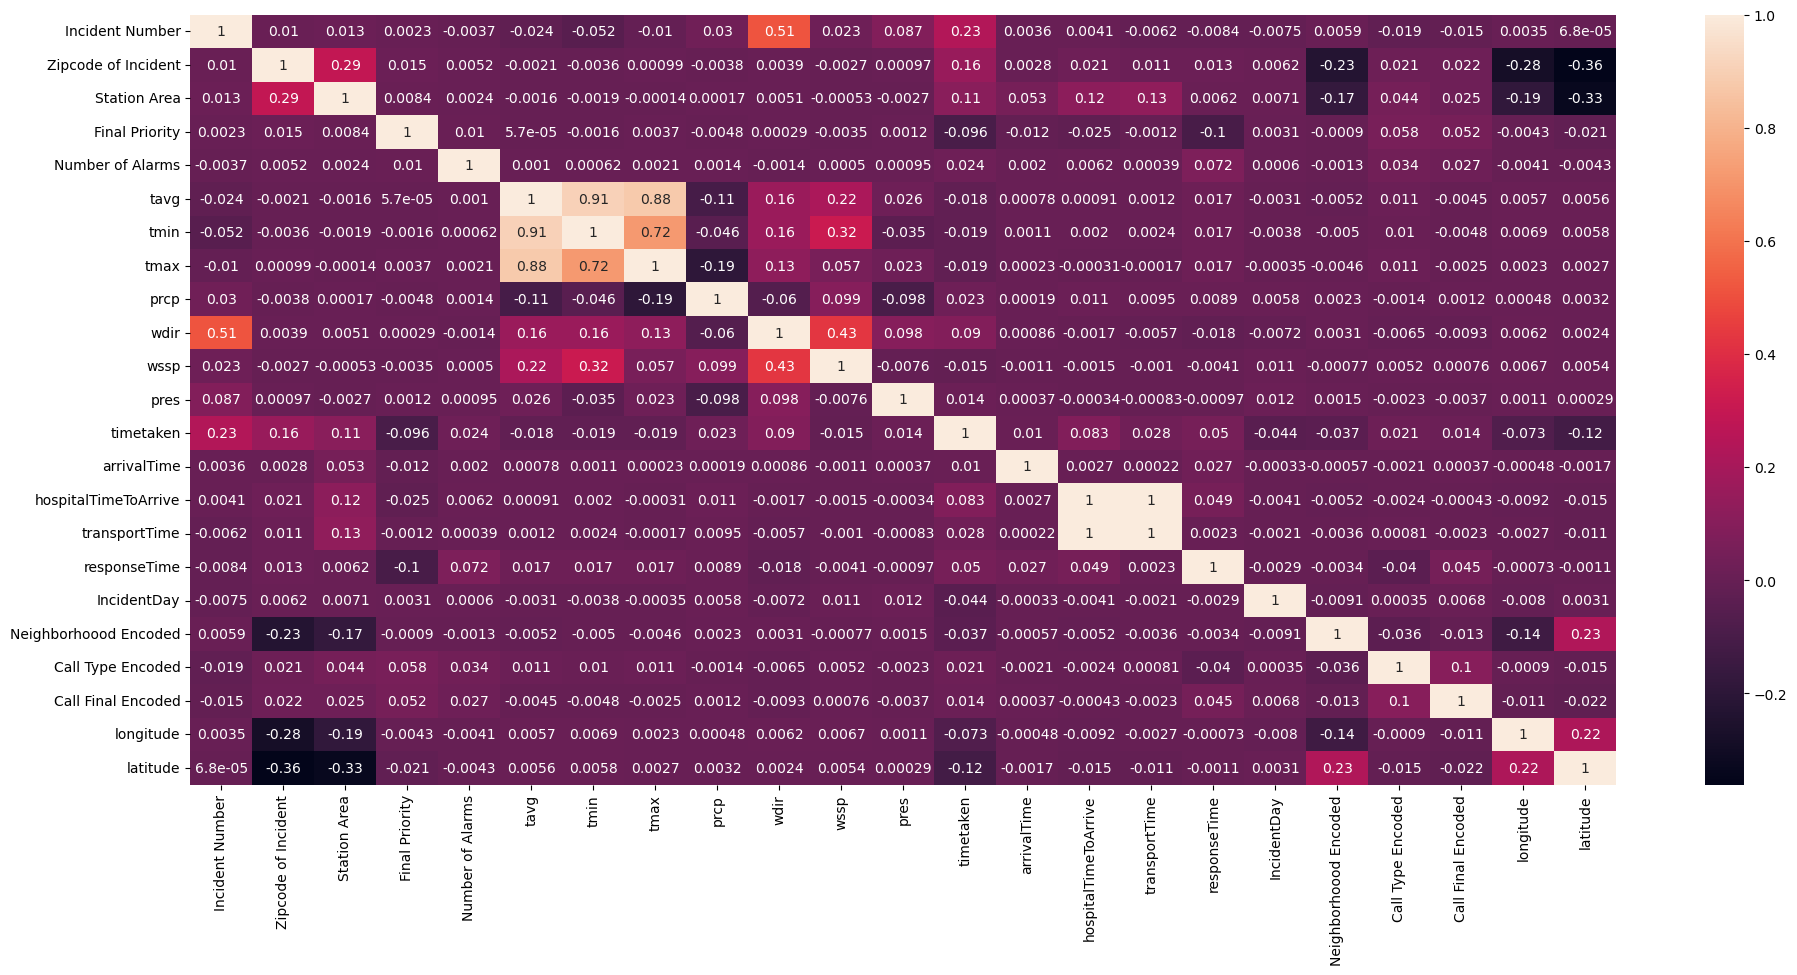

In [11]:
fig, ax = plt.subplots(figsize=(23, 10))
sns.heatmap(fire_department.drop(["tsun", "Call Number", "Call Type", "snow", "wpgt", "ALS Unit", "Unit sequence in call dispatch", "Analysis Neighborhoods", "Box"], 
                                 axis=1).corr(), annot=True)
plt.show()

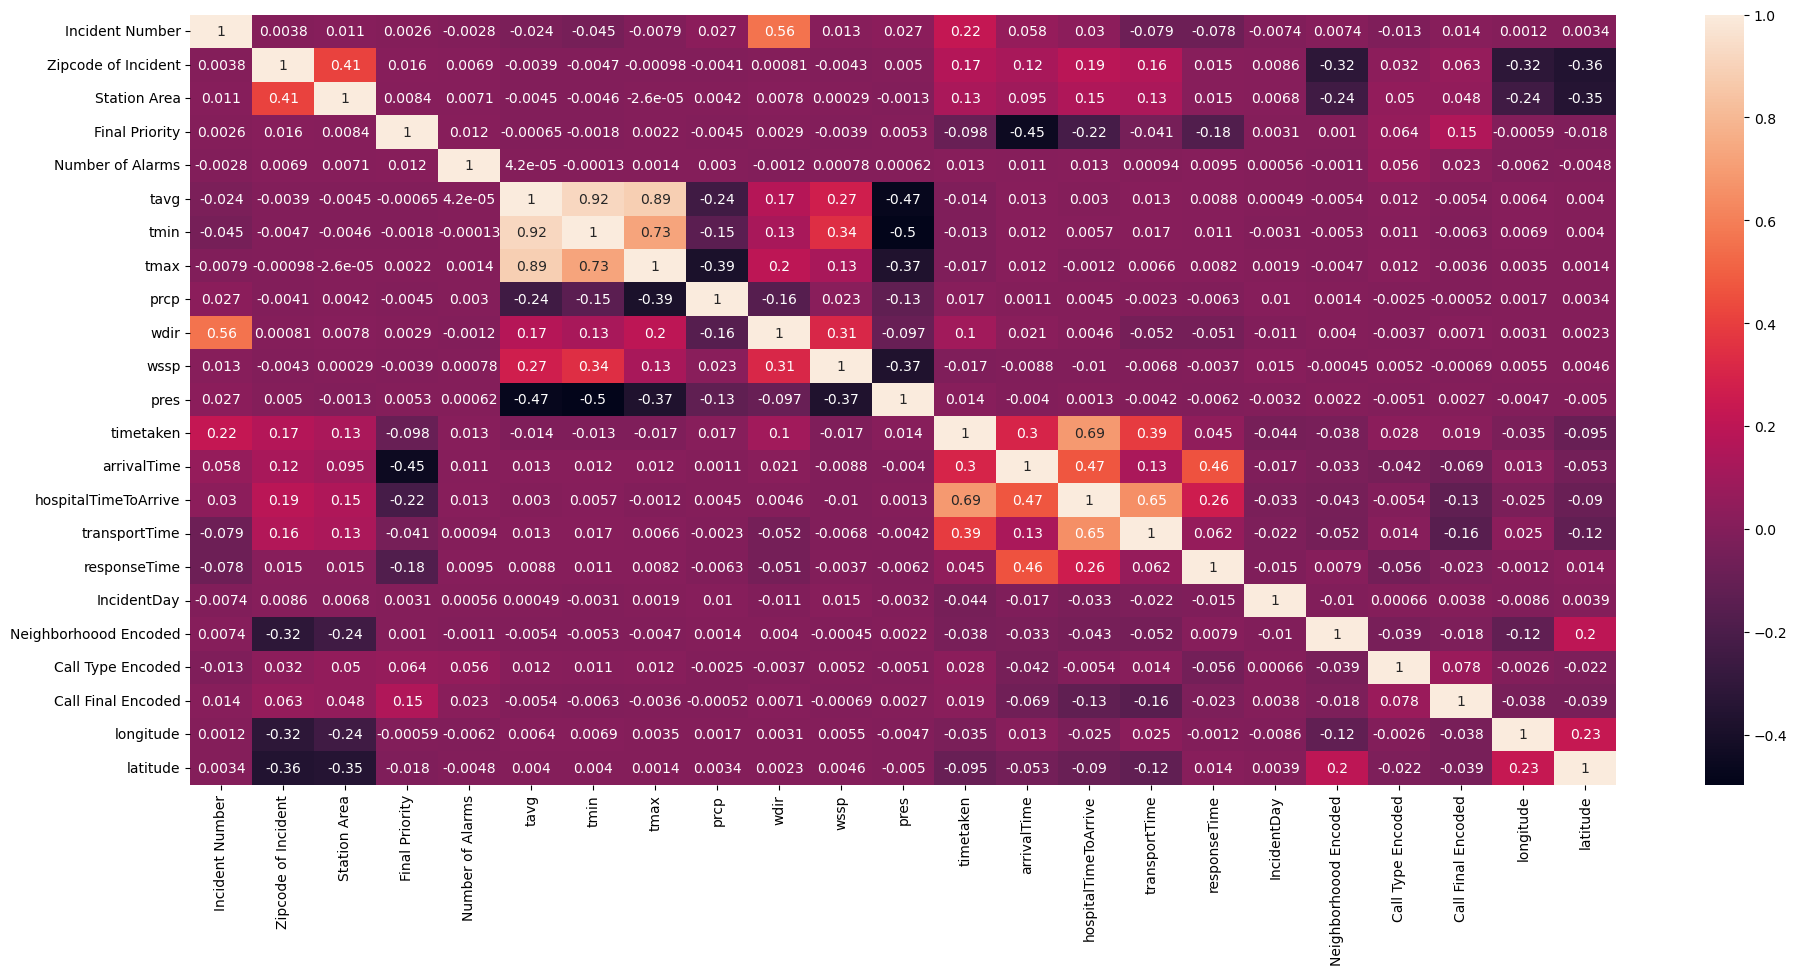

In [12]:
# Spearman correlation
fig, ax = plt.subplots(figsize=(23, 10))
sns.heatmap(fire_department.drop(["tsun", "Call Number", "Call Type", "snow", "wpgt", "ALS Unit", "Unit sequence in call dispatch", "Analysis Neighborhoods", "Box"], 
                                 axis=1).corr(method="spearman"), annot=True)
plt.show()

### EDA

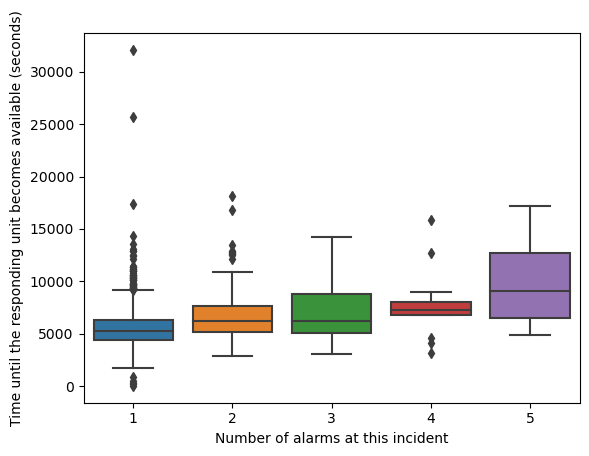

In [13]:
fire_filtered = fire_department[fire_department['Call Type Group'] == 'Fire']
sns.boxplot(x="Number of Alarms", y="timetaken", data=fire_filtered)
plt.xlabel('Number of alarms at this incident')
plt.ylabel('Time until the responding unit becomes available (seconds)')
plt.show()

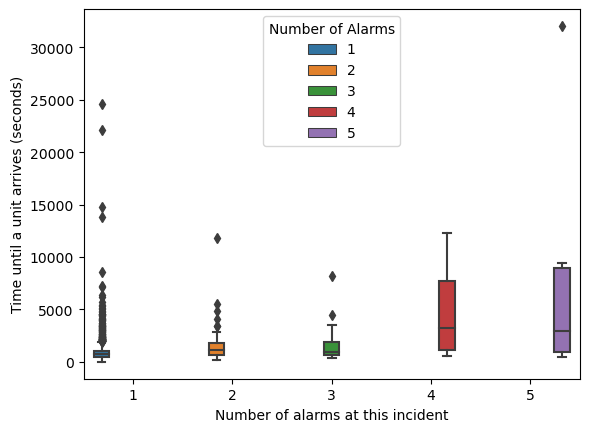

In [14]:
fire_filtered = fire_department[fire_department['Call Type Group'] == 'Fire']

sns.boxplot(x='Number of Alarms', y='arrivalTime', data=fire_filtered, hue='Number of Alarms')
plt.xlabel('Number of alarms at this incident')
plt.ylabel('Time until a unit arrives (seconds)')
plt.show()

## Linear Regression Machine Learning

In [15]:
num_cols = fire_department.select_dtypes(include='number').columns.tolist()
fire_department = fire_department.dropna()

In [16]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('timetaken', axis=1), fire_department[["timetaken"]])
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.5494133164565667
0.6543984249799175


,column,coefficient
28,latitude,-2.727562e+02
23,IncidentDay,-1.277200e+01
9,tavg,-8.203079e+00
15,wssp,-5.133397e+00
11,tmax,-2.176129e+00
22,responseTime,-1.130128e+00
8,Analysis Neighborhoods,-1.121957e+00
21,transportTime,-3.024364e-01
2,Zipcode of Incident,-2.509389e-01
14,wdir,-2.386578e-01


In [17]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('timetaken', axis=1), fire_department[["timetaken"]])
reg = linear_model.Ridge().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.5896435684770582
0.554311328652406


C:\Users\Sean4\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.11999e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


,column,coefficient
28,latitude,-319.427176
23,IncidentDay,-11.130307
9,tavg,-7.592522
15,wssp,-5.815356
11,tmax,-2.051185
22,responseTime,-1.066767
8,Analysis Neighborhoods,-0.314600
21,transportTime,-0.282741
14,wdir,-0.240993
1,Incident Number,-0.000528


In [18]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('timetaken', axis=1), fire_department[["timetaken"]])
reg = linear_model.Lasso(alpha=0.1, max_iter=10000).fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.5891299668282286
0.5569201881530138


C:\Users\Sean4\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.469e+09, tolerance: 3.634e+06
  model = cd_fast.enet_coordinate_descent(


,column,coefficient
0,Call Number,0.000062
26,Call Final Encoded,0.000062
25,Call Type Encoded,0.000062
24,Neighborhoood Encoded,0.000062
23,IncidentDay,0.000062
22,responseTime,0.000062
21,transportTime,0.000062
20,hospitalTimeToArrive,0.000062
19,arrivalTime,0.000062
18,tsun,0.000062


In [19]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('hospitalTimeToArrive', axis=1), fire_department[["hospitalTimeToArrive"]])
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.7568893622130914
0.6642514894250822


,column,coefficient
27,longitude,-1.043587e+03
5,Final Priority,-7.850206e+01
7,Unit sequence in call dispatch,-3.547097e+01
26,Call Final Encoded,-1.607646e+01
12,prcp,-3.942073e+00
25,Call Type Encoded,-3.491551e+00
9,tavg,-2.769852e+00
24,Neighborhoood Encoded,-1.141371e+00
17,pres,-1.100230e-01
4,Box,-7.236840e-03


In [20]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('responseTime', axis=1), fire_department[["responseTime"]])
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.5027041546636282
0.28697301171902334


,column,coefficient
6,Number of Alarms,-1.422166e+02
25,Call Type Encoded,-5.240222e+00
2,Zipcode of Incident,-1.433875e+00
9,tavg,-7.915980e-01
8,Analysis Neighborhoods,-5.926241e-01
3,Station Area,-5.037949e-01
23,IncidentDay,-1.191166e-01
19,timetaken,-7.703715e-02
22,transportTime,-5.902147e-02
14,wdir,-4.360027e-02


In [21]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('transportTime', axis=1), fire_department[["transportTime"]])
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.39135640598951726
0.3696174223661888


,column,coefficient
6,Number of Alarms,-8.248813e+02
28,latitude,-8.008596e+02
26,Call Final Encoded,-2.657970e+01
10,tmin,-7.996370e+00
23,IncidentDay,-4.035751e+00
24,Neighborhoood Encoded,-3.661606e+00
11,tmax,-2.426147e+00
15,wssp,-2.103879e+00
22,responseTime,-2.246529e-01
20,arrivalTime,-2.013567e-01


In [22]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('arrivalTime', axis=1), fire_department[["arrivalTime"]])
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
pd.DataFrame({"column": x_test.columns, "coefficient": reg.coef_[
             0]}).sort_values("coefficient")

0.3693040110439971
0.6731987790885112


,column,coefficient
28,latitude,-3.266402e+02
6,Number of Alarms,-2.916466e+02
5,Final Priority,-2.701116e+02
25,Call Type Encoded,-4.746568e+00
23,IncidentDay,-2.718897e+00
24,Neighborhoood Encoded,-1.197097e+00
15,wssp,-1.041125e+00
11,tmax,-6.935207e-01
21,transportTime,-1.204355e-01
26,Call Final Encoded,-7.027819e-02


##  decision trees

In [23]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('Call Final Encoded', axis=1), fire_department[["Call Final Disposition"]], random_state=42)

dtc = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = dtc.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 score: {f1:.2f}')
importances = dtc.feature_importances_
cols = fire_department[num_cols].drop('Call Final Encoded', axis=1).columns.tolist()
feat_importances = list(zip(cols, importances))
feat_importances.sort(key=lambda x: x[1], reverse=True)
for feat in feat_importances:
    print(feat[0], feat[1])

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 score: 0.88
transportTime 0.10763003684084978
timetaken 0.10170182979505397
hospitalTimeToArrive 0.10061744121053863
latitude 0.07629546636249346
longitude 0.06969840077991678
responseTime 0.0513056177457806
arrivalTime 0.04716763361130654
Box 0.0432004723392216
Incident Number 0.03639740919294244
wdir 0.03632669282803922
Final Priority 0.03595514004526993
pres 0.0322490231388054
tavg 0.03159079761107244
Call Number 0.029494724718941698
wssp 0.02683211507201503
tmax 0.025468321574570463
Station Area 0.021749711553203734
tmin 0.021700287235218354
Unit sequence in call dispatch 0.020986767989047916
Zipcode of Incident 0.01726209376914235
IncidentDay 0.016722230528121943
Neighborhoood Encoded 0.014665194171269694
Analysis Neighborhoods 0.014291554172719368
Call Type Encoded 0.010818380157330318
prcp 0.009872657557128465
Number of Alarms 0.0
snow 0.0
wpgt 0.0
tsun 0.0


C:\Users\Sean4\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fire_department[num_cols].drop('Call Type Encoded', axis=1), fire_department[["Call Type"]], random_state=42)

dtc = DecisionTreeClassifier().fit(x_train, y_train)

y_pred = dtc.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 score: {f1:.2f}')
importances = dtc.feature_importances_
cols = fire_department[num_cols].drop('Call Final Encoded', axis=1).columns.tolist()
feat_importances = list(zip(cols, importances))
feat_importances.sort(key=lambda x: x[1], reverse=True)
for feat in feat_importances:
    print(feat[0], feat[1])

Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1 score: 0.93
responseTime 0.08629890630739848
hospitalTimeToArrive 0.07076684727983178
longitude 0.06519268588076009
Unit sequence in call dispatch 0.06431953003014836
arrivalTime 0.06276206860145521
Box 0.06031643426901555
transportTime 0.057531240370488845
timetaken 0.05452648226622867
wssp 0.0514264952998802
latitude 0.04912159838010613
wdir 0.040797784747895104
pres 0.039172552525684495
Station Area 0.036480900481389515
Incident Number 0.03627095785568119
Call Number 0.0320517582563689
Zipcode of Incident 0.031690794099063606
tavg 0.031657441439938844
tmax 0.026177884417379255
tmin 0.02171128677569651
Call Type Encoded 0.019766100761654005
IncidentDay 0.017092758962062
Analysis Neighborhoods 0.016794754104945873
Neighborhoood Encoded 0.016085435744663448
prcp 0.006197005859220132
Final Priority 0.005790295283043803
Number of Alarms 0.0
snow 0.0
wpgt 0.0
tsun 0.0


C:\Users\Sean4\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sean4\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
